<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQR_QP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

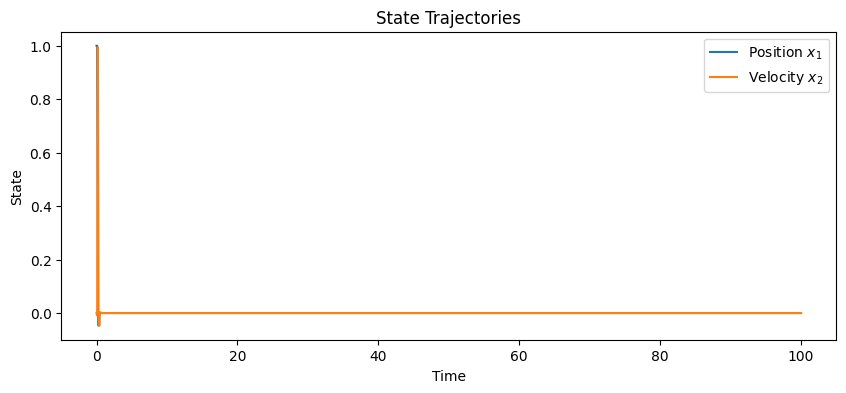

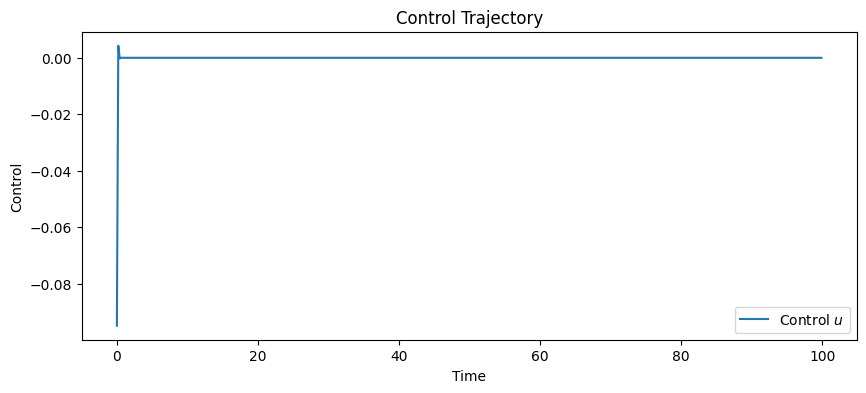

Total cost J = 1.497152423920122


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import block_diag, eye, kron
from scipy.linalg import solve

# System Dynamics
h = 0.1
A = np.array([[1, h],
              [0, 1]])
B = np.array([[0.5 * h**2],
              [h]])

n, m = 2, 1
Tfinal = 100.0
N = int(Tfinal / h) + 1
times = np.linspace(0, h * (N - 1), N)

# Initial condition
x0 = np.array([1.0, 0.0])

# Cost matrices
Q = 1.0 * np.eye(n)
R = 0.1 * np.eye(m)
Qn = 1.0 * np.eye(n)

def J(xhist, uhist):
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(N - 1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k]
        cost += 0.5 * uhist[k] * R * uhist[k]
    return cost

# Build cost matrix H
blocks = []
for k in range(N - 2):
    blocks.append(np.block([[R, np.zeros((m, n))],
                            [np.zeros((n, m)), Q]]))
blocks.append(np.block([[R, np.zeros((m, n))],
                        [np.zeros((n, m)), Qn]]))  # terminal Q
H = block_diag(blocks).toarray()

# Build dynamics constraints matrix C and RHS d
rows = []
d = []
block_B_negI = np.hstack((B, -np.eye(n)))  # (2 x 3)

for k in range(N - 1):
    row = np.zeros((n, (n + m) * (N - 1)))
    idx = k * (n + m)

    if k > 0:
        row[:, idx - (n + m): idx - m] = A

    row[:, idx:idx + m + n] = block_B_negI

    rows.append(row)
    if k == 0:
        d.append(-A @ x0)
    else:
        d.append(np.zeros(n))

C = np.vstack(rows)
d = np.concatenate(d)

# Solve KKT system
KKT_matrix = np.block([
    [H, C.T],
    [C, np.zeros((C.shape[0], C.shape[0]))]
])
rhs = np.concatenate([np.zeros(H.shape[0]), d])
solution = solve(KKT_matrix, rhs)

# Extract control/state trajectory
z = solution[:H.shape[0]]
Z = z.reshape((n + m, N - 1), order='F')
xhist = np.hstack((x0[:, None], Z[m:, :]))
uhist = Z[0, :]

# Plot states
plt.figure(figsize=(10, 4))
plt.plot(times, xhist[0, :], label="Position $x_1$")
plt.plot(times, xhist[1, :], label="Velocity $x_2$")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title("State Trajectories")

# Plot control
plt.figure(figsize=(10, 4))
plt.plot(times[:-1], uhist, label="Control $u$")
plt.xlabel("Time")
plt.ylabel("Control")
plt.legend()
plt.title("Control Trajectory")

plt.show()

# Evaluate cost
print("Total cost J =", J(xhist, uhist).item())
